# Data Analysis of CK+ and OpenFace output

In this notebook we analyze data taken from the [CK+ dataset](http://www.consortium.ri.cmu.edu/ckagree/) and the processing results of the images in the dataset through the [OpenFace](https://github.com/TadasBaltrusaitis/OpenFace) toolkit.

The aim of this analysis is to evaluate the quality and characteristics of the data. The results from the analysis will lead our choices in the implementation of several techniques of emotion detection.

The data is structured as follows.
Each row represents an image and the informations in each row are:
- `img_name` - the name of the image in the dataset
- `emotion` - the emotion value taken from the dataset
- `true_AU**` - the FACS labels taken from the dataset
- `AU**_r` - the regression output from OpenFace
- `AU**_c` - the classification output from OpenFace

The OpenFace system is executed from short videos obtained by merging the image sequences in the dataset. This approach gives way better results than by executing it on single images.

After the general analysis of the data, we compare it with the a theoretical probability of activation of the action units, taken from [literature](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/Ruiz_From_Emotions_to_ICCV_2015_paper.pdf). In this document we will call it **EMO-AU** matrix, for simplicity.

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

%matplotlib inline

## Data Collection

In [2]:
# Path to the local dataset file
DATASET_PATH = "../data/labeled_fromvids.csv"

In [3]:
# Load the dataset with Pandas
data = pd.read_csv(DATASET_PATH)
print("Shape of the dataset: {}".format(data.shape))
data.head()
# NOTE: the first line of the file is considered as the header

Shape of the dataset: (327, 77)


,Unnamed: 0,img_name,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,...,true_AU39,true_AU43,true_AU44,true_AU45,true_AU54,true_AU61,true_AU62,true_AU63,true_AU64,emotion
0,0,S045_005_00000030,0.0000,0.0000,1.2080,0.06633,0.1355,1.9680,0.00000,0.000,...,0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,1
1,1,S026_002_00000016,0.4886,0.1114,0.5620,0.00000,0.0000,0.0000,0.00000,0.000,...,0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,6
2,2,S086_002_00000015,0.0000,0.0000,0.0000,0.00000,1.7440,3.6200,0.04111,1.348,...,0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,5
3,3,S116_001_00000014,0.1779,0.0000,0.9914,0.00000,0.0000,0.2461,0.00000,0.000,...,0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,7
4,4,S056_004_00000020,0.0000,0.0000,0.0000,0.00000,1.7840,1.7600,0.35070,2.286,...,0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,5


In [4]:
data.describe(include='all')

,Unnamed: 0,img_name,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,...,true_AU39,true_AU43,true_AU44,true_AU45,true_AU54,true_AU61,true_AU62,true_AU63,true_AU64,emotion
count,327.000000,327,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,...,327.000000,327.000000,327.0,327.000000,327.000000,327.0,327.000000,327.000000,327.000000,327.000000
unique,NaN,327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,S032_006_00000016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,163.000000,NaN,0.337782,0.062853,0.664089,0.063753,0.650706,1.292309,0.220256,0.416086,...,-0.024465,0.003058,0.0,0.045872,0.006116,0.0,0.009174,0.009174,0.009174,4.440367
std,94.540996,NaN,0.708521,0.215959,0.892052,0.207669,0.839389,1.246935,0.416289,0.632016,...,0.154724,0.123806,0.0,0.400582,0.110600,0.0,0.165900,0.123503,0.123503,2.072747
min,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000
25%,81.500000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.014780,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.000000
50%,163.000000,NaN,0.000000,0.000000,0.168200,0.000000,0.005563,1.022000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,5.000000
75%,244.500000,NaN,0.300150,0.000000,1.086500,0.000000,1.308000,2.367500,0.223250,0.748550,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,7.000000


### Checking for any Missing Values

In [5]:
# Check if there is any missing value in the whole dataset
print("There are missing values in the dataset: {}".
     format(data.isnull().any().any()))

There are missing values in the dataset: False


## Data Exploration

In [6]:
# Create a lambda function which will be applied to each entry
# of the numpy 2-D array of AxesSubplot objects
# x is a reference to an AxesSubplot object
y_labeler = lambda x: x.set_ylabel('density')
# np.vectorize() allows calling the function on each element
y_labeler = np.vectorize(y_labeler)

### Action Units true values

Here we plot the distributions of the true FACS values from the dataset.

#### Removing empty columns

In [7]:
AUtrue_cols = [col for col in data.columns.values if col[:4] == 'true']
true_AUs = data[AUtrue_cols]
print(true_AUs.shape)
true_AUs = true_AUs.loc[:, (true_AUs != 0).any(axis=0)]
print(true_AUs.shape)

(327, 39)
(327, 35)


There are no empty columns fortunately.

#### Distribution plot

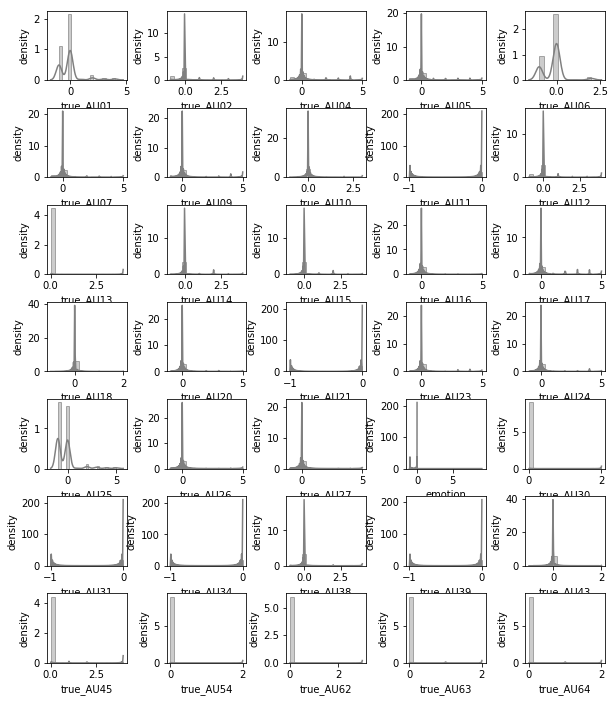

In [8]:
# Create a Figure containing 2x2 subplots
fig, axes = plt.subplots(7, 5, figsize=(10,12))
# Call the vectorized function for labeling all the y-axes
y_labeler(axes)

for i,col in enumerate(true_AUs.columns.values):
    _ = sns.distplot(true_AUs[col], color='#808080', ax=axes[math.floor(i/5),i%5], 
                     hist_kws=dict(edgecolor="#404040", linewidth=1))
    
_ = sns.distplot(data["emotion"], color='#808080', ax=axes[4,3], 
                     hist_kws=dict(edgecolor="#404040", linewidth=1))

# Adjust space between plots
plt.subplots_adjust(wspace=.5, hspace=.4)

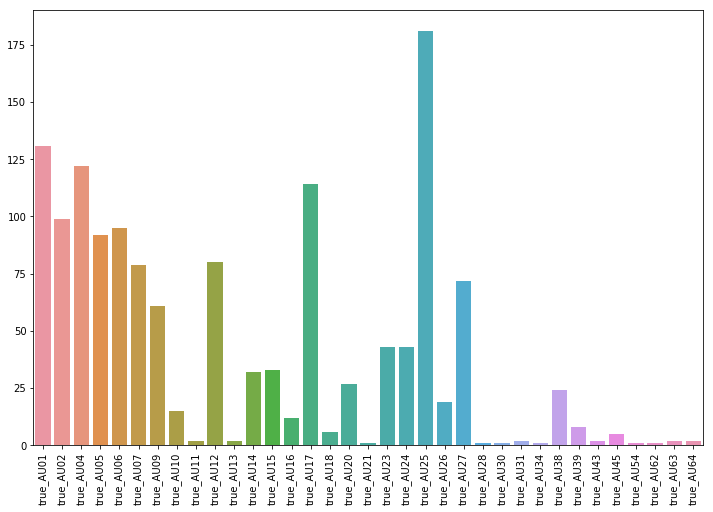

In [9]:
fig = plt.figure(figsize=(12,8))

_ = sns.barplot(x=true_AUs.columns.values,y=true_AUs[true_AUs != 0].count())
for item in _.get_xticklabels():
    item.set_rotation(90)

### OpenFace regression data

Here we plot the distributions of the FACS values computed by the regression model from OpenFace.

#### Removing empty columns

In [10]:
AUr_cols = [col for col in data.columns.values if col[:2] == 'AU' and col[-2:] == "_r"]

reg_AUs = data[AUr_cols]
print(reg_AUs.shape)
reg_AUs = reg_AUs.loc[:, (reg_AUs != 0).any(axis=0)]
print(reg_AUs.shape)



(327, 17)
(327, 17)


There are no empty columns.

#### Distribution plot

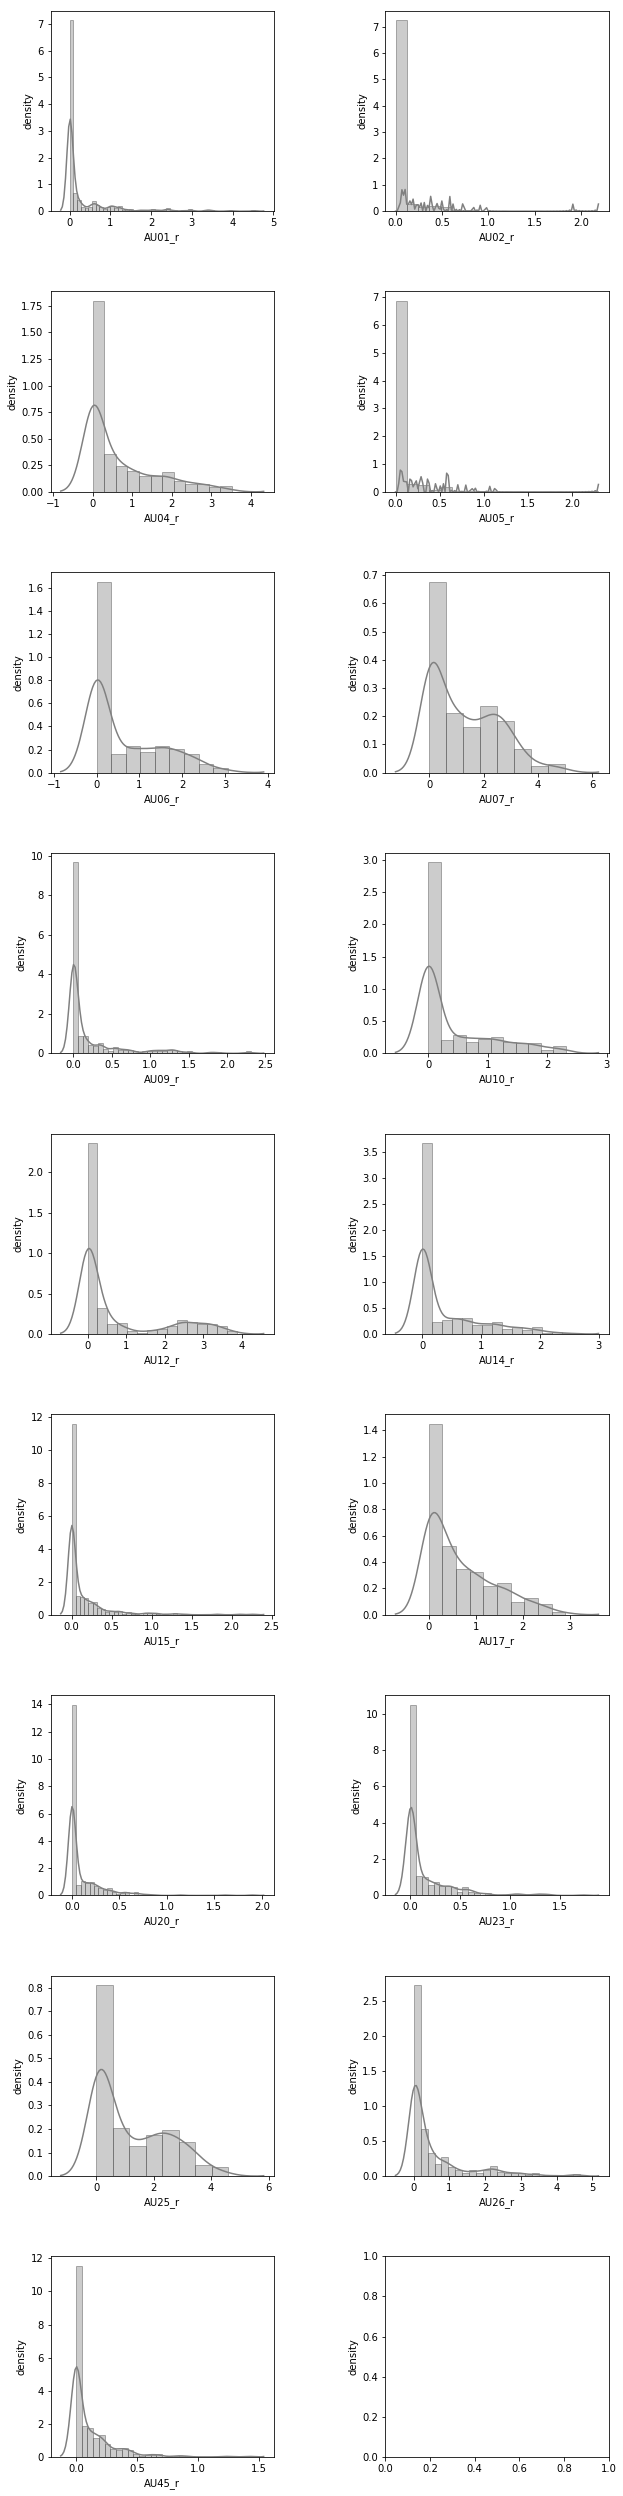

In [11]:
# Create a Figure containing 2x2 subplots
fig, axes = plt.subplots(9, 2, figsize=(10,45))
# Call the vectorized function for labeling all the y-axes
y_labeler(axes)

for i,col in enumerate(reg_AUs.columns.values):
    _ = sns.distplot(reg_AUs[col], color='#808080', ax=axes[math.floor(i/2),i%2], 
                     hist_kws=dict(edgecolor="#404040", linewidth=1))
    

# Adjust space between plots
plt.subplots_adjust(wspace=.5, hspace=.4)

The distribution of the Action Unit intensities seems pausible and not random. 
They are very likely to be equal to 0 in general.

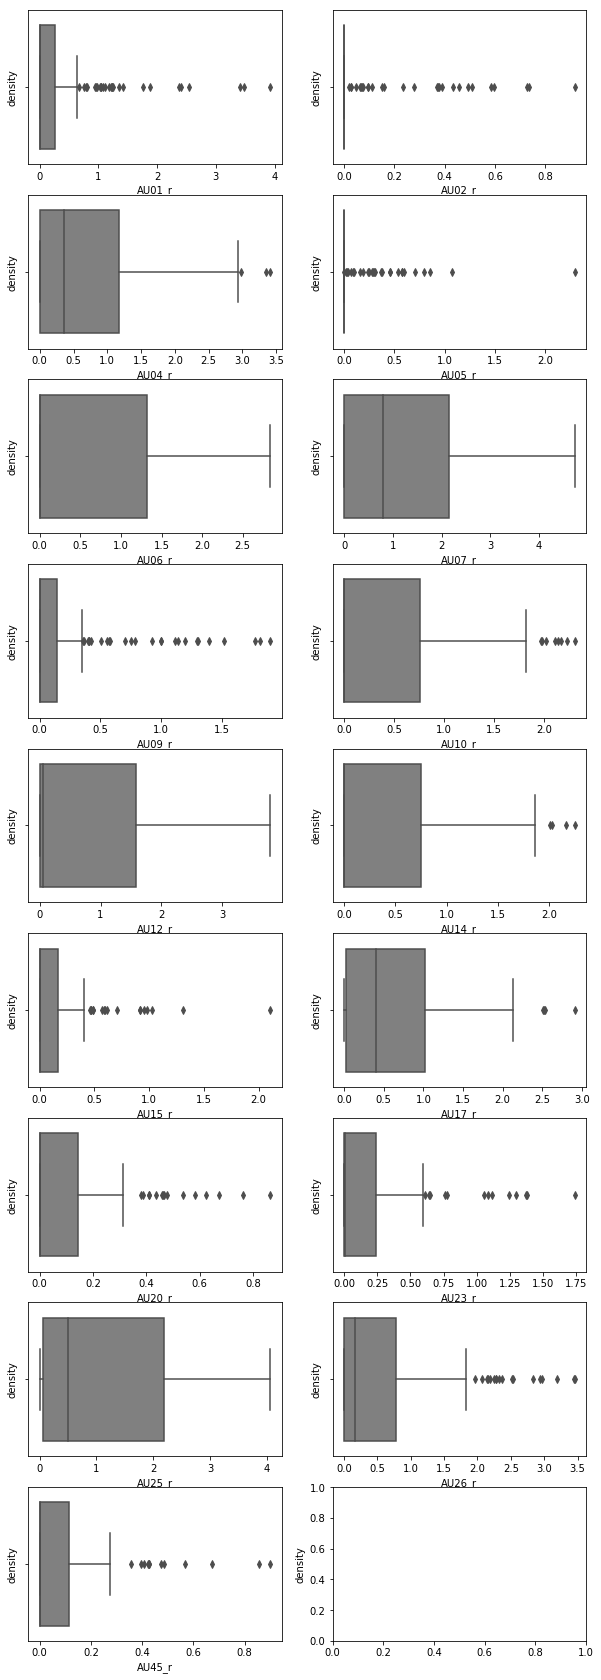

In [12]:
# Let's produce the boxplots corresponding to the distribution plots above
# Create a Figure containing 2x2 subplots
# Create a Figure containing 2x2 subplots
fig, axes = plt.subplots(9, 2, figsize=(10,30))
# Call the vectorized function for labeling all the y-axes
y_labeler(axes)

for i,col in enumerate(reg_AUs.columns.values):
    _ = sns.boxplot(reg_AUs[col].sample(150), color='#808080', ax=axes[math.floor(i/2),i%2])

### OpenFace classification data

Here we plot the distributions of the FACS values computed by the classification model from OpenFace.

#### Removing empty columns

In [13]:
AUc_cols = [col for col in data.columns.values if col[:2] == 'AU' and col[-2:] == "_c"]

clf_AUs = data[AUc_cols]
print(clf_AUs.shape)
clf_AUs = clf_AUs.loc[:, (clf_AUs != 0).any(axis=0)]
print(clf_AUs.shape)


(327, 18)
(327, 18)


There are no empty columns.

#### Distribution plot

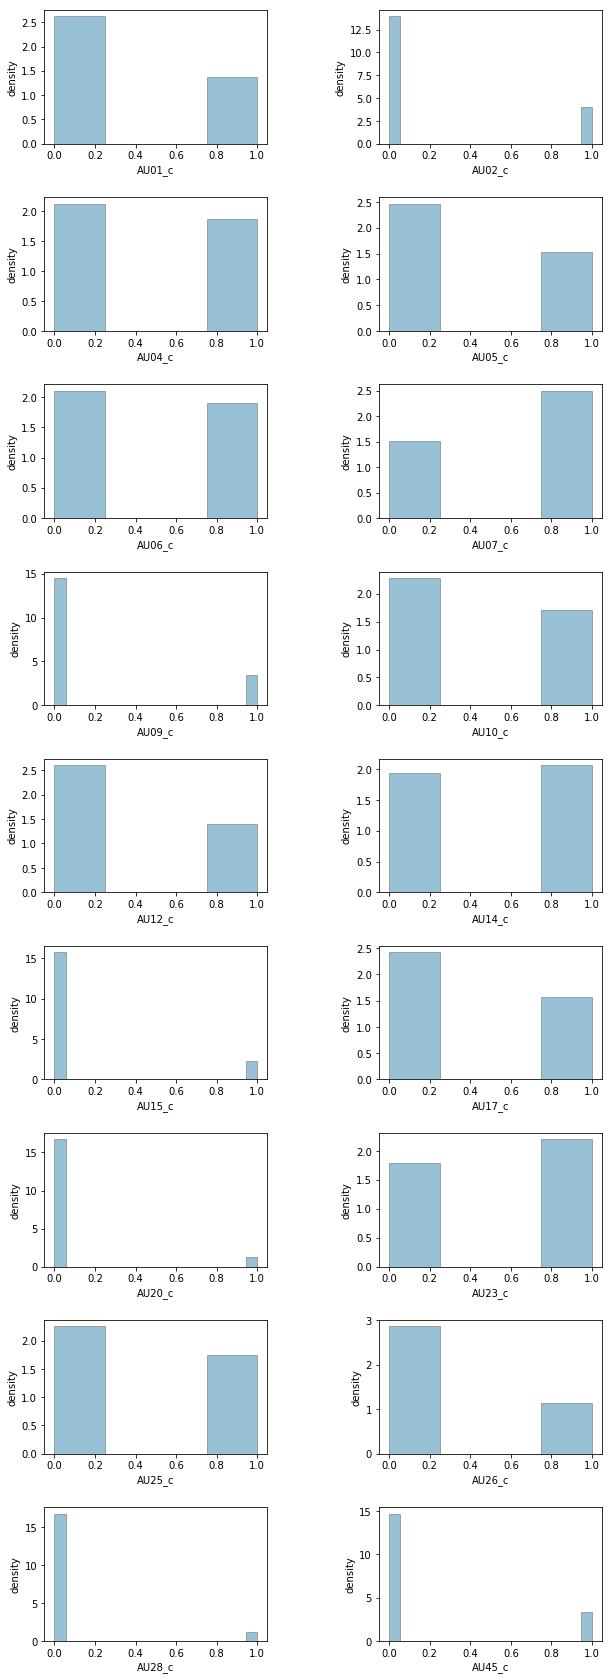

In [14]:
# Let's produce the boxplots corresponding to the distribution plots above
# Create a Figure containing 2x2 subplots
fig, axes = plt.subplots(9, 2, figsize=(10,30))
y_labeler(axes)

for i,col in enumerate(clf_AUs.columns.values):
    _ = sns.distplot(clf_AUs[col], color='#006699', ax=axes[math.floor(i/2),i%2], 
                 kde=False, norm_hist=True,
                 hist_kws=dict(edgecolor="#404040", linewidth=1))

# Adjust space between plots
plt.subplots_adjust(wspace=.5, hspace=.4)

The classification data seems more balanced than the regression one. 

## Compare data with the EMO-AU matrix

In this section we will compare the a-priori matrix obtained from [literature](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/Ruiz_From_Emotions_to_ICCV_2015_paper.pdf).

First we will compare it with the true FACS labels taken from the dataset, then with the OpenFace FACS output, both regression and classification.

In [15]:
emo_map = { 0:'neutral',
           1:'anger',
           2:'contempt',
           3:'disgust',
           4:'fear',
           5:'happy',
           6:'sadness',
           7:'surprise'
          }

emo_map_inv = dict((v, k) for k, v in emo_map.items())


emo_matrix = { 'neutral':  [0,0,0,0,0,0,0,0,0,0,0,0,0,0],
               'anger':    [0.17,0.1,0.33,0.25,0.03,0.05,0.,0.1,0.,0.05,0.06,0.4,0.31,0.49],
               'disgust':  [0.01,0.01,0.35,0.01,0.06,0.36,0.06,0.21,0.,0.,0.,0.25,0.32,0.40],
               'fear':     [0.12,0.01,0.33,0.55,0.00,0.29,0.,0.03,0.,0.04,0.04,0.25,0.2,0.75],
               'happy':    [0.07,0.09,0.01,0.05,0.94,0.01,0.05,0.,0.92,0.,0.,0.02,0.34,0.55],
               'sadness':  [0.22,0.01,0.25,0.,0.03,0.39,0.,0.05,0.05,0.09,0.17,0.07,0.14,0.2],
               'surprise': [0.15,0.19,0.08,0.76,0.,0.02,0.,0.1,0.04,0.,0.04,0.09,0.26,0.72]
             }

In [18]:
lbl_counts = data['emotion'].value_counts()

#### Compare EMO-AU matrix with true labels from dataset

In [19]:
true_AU_mat = [
    "true_AU01",
    "true_AU02",
    "true_AU04",
    "true_AU05",
    "true_AU06",
    "true_AU07",
    "true_AU09",
    "true_AU10",
    "true_AU12",
    "true_AU15",
    "true_AU17",
    "true_AU20",
    "true_AU25",
    "true_AU26"
]

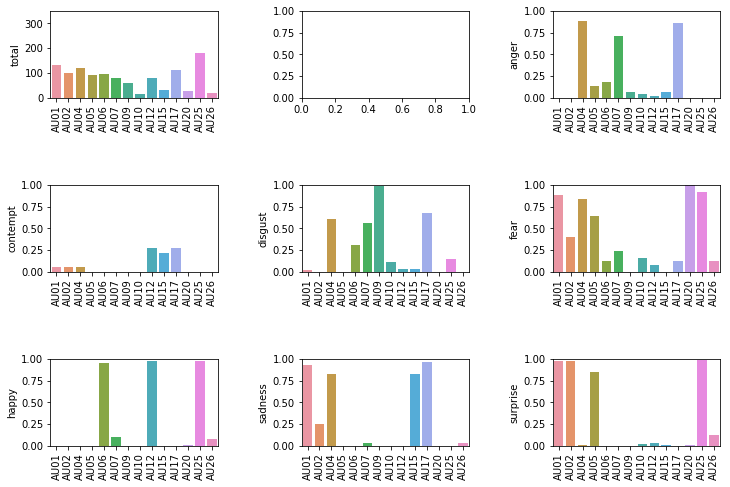

In [20]:
fig, axes = plt.subplots(3, 3, figsize=(12,8))

AUmat_lbl = [el[5:9] for el in true_AU_mat]
axes[0,0].set_ylabel("total")
axes[0,0].set(ylim=(0,350))

_ = sns.barplot(x=AUmat_lbl,y=data[true_AU_mat][data[true_AU_mat] != 0].count(), ax=axes[0,0])
for item in _.get_xticklabels():
    item.set_rotation(90)

for i in range(1,8):
    axes[math.floor((i+1)/3),(i+1)%3].set_ylabel(emo_map[i])
    axes[math.floor((i+1)/3),(i+1)%3].set(ylim=(0,1))
    _ = sns.barplot(x=AUmat_lbl, 
                    y=data.loc[lambda data: data.emotion == i, true_AU_mat][data[true_AU_mat] != 0].count()/lbl_counts[i], 
                    ax=axes[math.floor((i+1)/3),(i+1)%3])
    for item in _.get_xticklabels():
        item.set_rotation(90)

plt.subplots_adjust(wspace=.5, hspace=1.0)

Here we compare the distribution of the true labels from dataset (on the left column) to the proabilities in the matrix (on the right column), grouped by emotion.

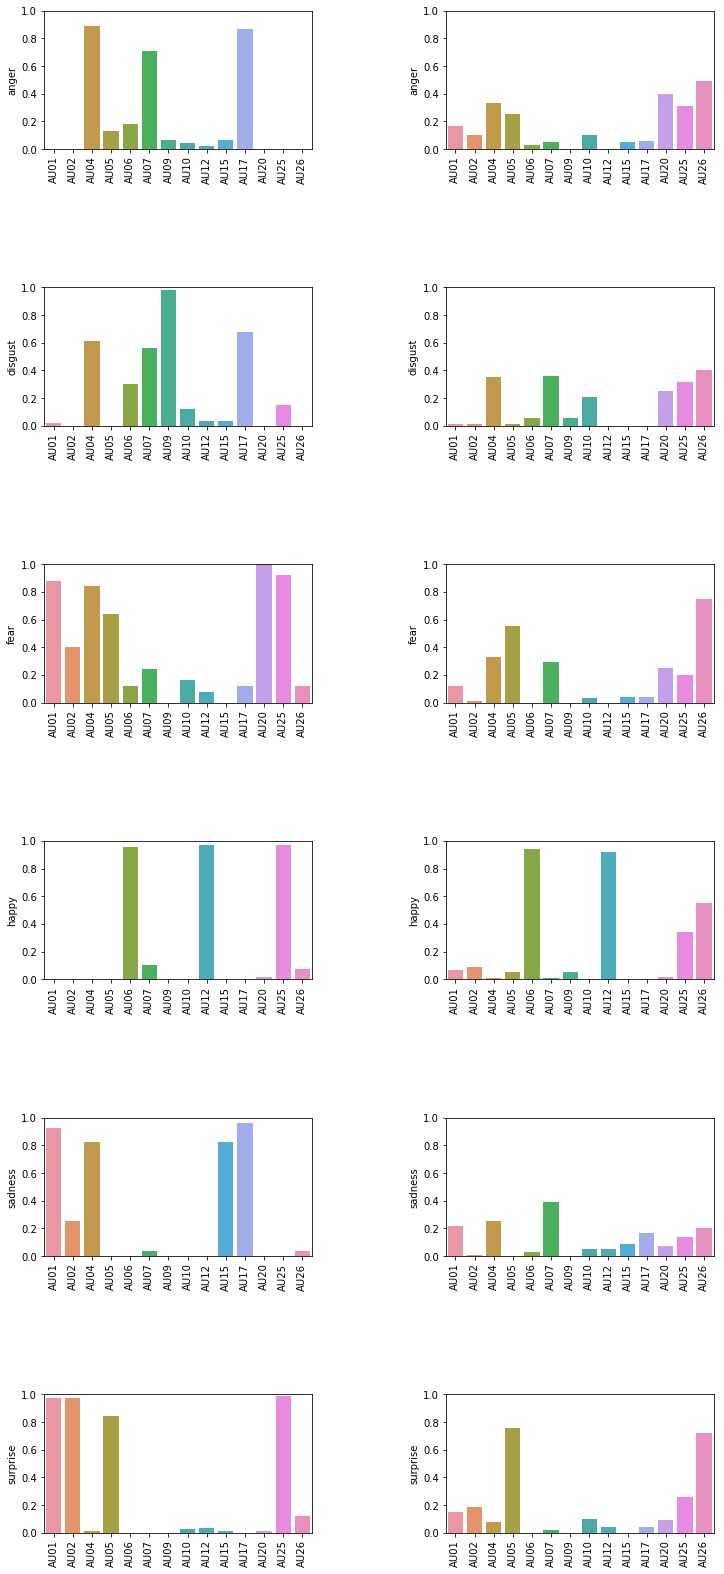

In [21]:
fig, axes = plt.subplots(6, 2, figsize=(12,28))

i = 0
for emo in emo_map.values():

    if emo in emo_matrix.keys() and len(emo_matrix.keys())>i and emo_map_inv[emo] in lbl_counts:
        emo_data = data.loc[lambda data: data.emotion == emo_map_inv[emo], :]
        axes[i,0].set_ylabel(emo)
        axes[i,0].set(ylim=(0,1))
        _ = sns.barplot(x=AUmat_lbl,
                        y=emo_data[true_AU_mat][emo_data[true_AU_mat] != 0].count()/lbl_counts[emo_map_inv[emo]],
                        ax=axes[i,0]
                       )
        
        for item in _.get_xticklabels():
            item.set_rotation(90)
        
        axes[i,1].set_ylabel(emo)
        axes[i,1].set(ylim=(0,1))

        _ = sns.barplot(x=AUmat_lbl,y=emo_matrix[emo], ax=axes[i,1])

        for item in _.get_xticklabels():
            item.set_rotation(90)
        
        i = i+1
    

plt.subplots_adjust(wspace=.5, hspace=1.0)

As expected the distributions of the FACS true values are very close to the matrix values.

#### Distribution of regression AUs depeding on emotion

In [22]:
AUr_mat = [
    "AU01_r",
    "AU02_r",
    "AU04_r",
    "AU05_r",
    "AU06_r",
    "AU07_r",
    "AU09_r",
    "AU10_r",
    "AU12_r",
    "AU15_r",
    "AU17_r",
    "AU20_r",
    "AU25_r",
    "AU26_r"
]

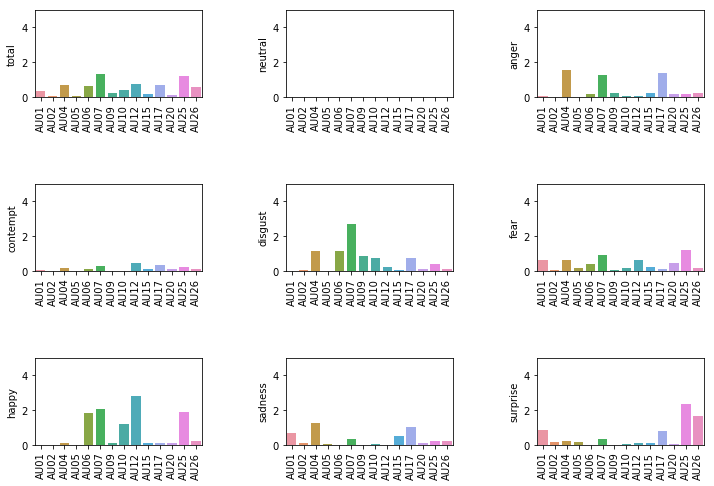

In [23]:
fig, axes = plt.subplots(3, 3, figsize=(12,8))

AUmat_lbl = [el[:4] for el in AUr_mat]
axes[0,0].set_ylabel("total")
axes[0,0].set(ylim=(0,5))

_ = sns.barplot(x=AUmat_lbl,y=data.loc[:, AUr_mat].mean(), ax=axes[0,0])
for item in _.get_xticklabels():
    item.set_rotation(90)

for i in range(0,8):
    axes[math.floor((i+1)/3),(i+1)%3].set_ylabel(emo_map[i])
    axes[math.floor((i+1)/3),(i+1)%3].set(ylim=(0,5))
    _ = sns.barplot(x=AUmat_lbl,y=data.loc[lambda data: data.emotion == i, AUr_mat].mean(), ax=axes[math.floor((i+1)/3),(i+1)%3])
    for item in _.get_xticklabels():
        item.set_rotation(90)

plt.subplots_adjust(wspace=.5, hspace=1.0)

#### Compare EMO-AU matrix with the OpenFace regression output

Here we compare the average of the FACS values computed using the OpenFace regression model (on the left column) and the proabilities in the matrix (on the right column), grouped by emotion.

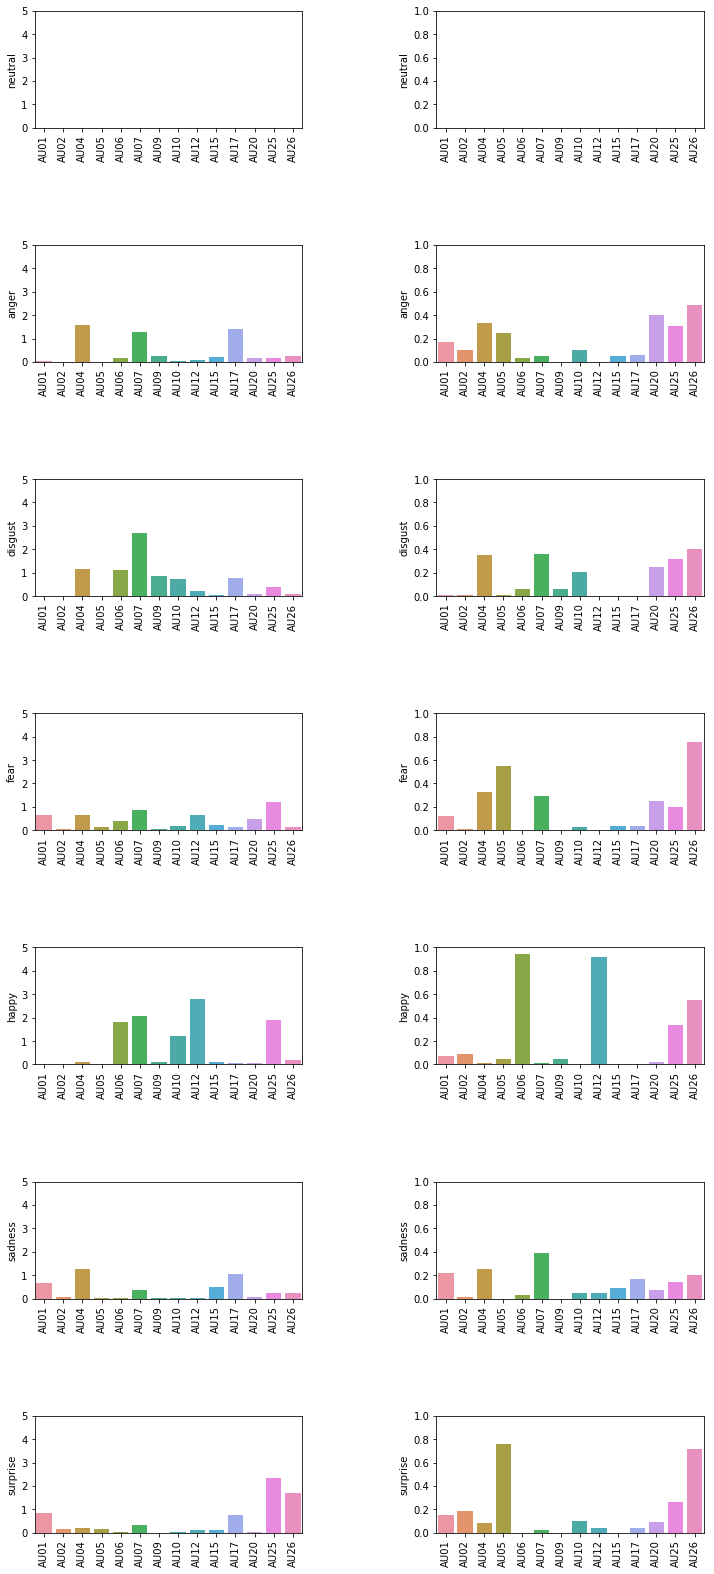

In [24]:
fig, axes = plt.subplots(7, 2, figsize=(12,28))

i = 0
for emo in emo_map.values():

    if emo in emo_matrix.keys() and len(emo_matrix.keys())>i:

        axes[i,0].set_ylabel(emo)
        axes[i,0].set(ylim=(0,5))
        _ = sns.barplot(x=AUmat_lbl,
                        y=data.loc[lambda data: data.emotion == emo_map_inv[emo], AUr_mat].mean(),
                        ax=axes[i,0]
                       )
        
        for item in _.get_xticklabels():
            item.set_rotation(90)
        
        axes[i,1].set_ylabel(emo)
        axes[i,1].set(ylim=(0,1))

        _ = sns.barplot(x=AUmat_lbl,y=emo_matrix[emo], ax=axes[i,1])

        for item in _.get_xticklabels():
            item.set_rotation(90)
        
        i = i+1
    

plt.subplots_adjust(wspace=.5, hspace=1.0)

The distributions of the regression output are plausible and show some affinity with the matrix, but it is not clear if its possible to infer the right emotion directly by comparing them.

#### Distribution of classification AUs depeding on emotion

In [25]:
AUc_mat = [
    "AU01_c",
    "AU02_c",
    "AU04_c",
    "AU05_c",
    "AU06_c",
    "AU07_c",
    "AU09_c",
    "AU10_c",
    "AU12_c",
    "AU15_c",
    "AU17_c",
    "AU20_c",
    "AU25_c",
    "AU26_c"
]

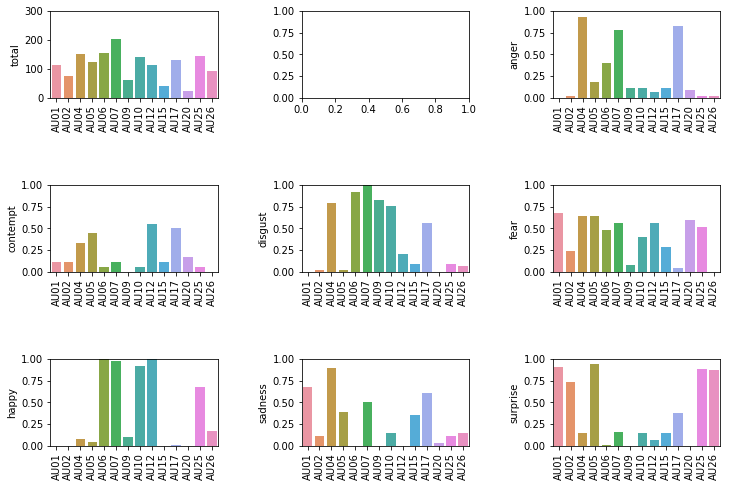

In [26]:
fig, axes = plt.subplots(3, 3, figsize=(12,8))

AUmat_lbl = [el[:4] for el in AUc_mat]
axes[0,0].set_ylabel("total")
axes[0,0].set(ylim=(0,300))

_ = sns.barplot(x=AUmat_lbl,y=data.loc[:, AUc_mat].sum(), ax=axes[0,0])
for item in _.get_xticklabels():
    item.set_rotation(90)

for i in range(1,8):
    axes[math.floor((i+1)/3),(i+1)%3].set_ylabel(emo_map[i])
    axes[math.floor((i+1)/3),(i+1)%3].set(ylim=(0,1))
    _ = sns.barplot(x=AUmat_lbl,y=data.loc[lambda data: data.emotion == i, AUc_mat].sum()/lbl_counts[i], ax=axes[math.floor((i+1)/3),(i+1)%3])
    for item in _.get_xticklabels():
        item.set_rotation(90)

plt.subplots_adjust(wspace=.5, hspace=1.0)

#### Compare EMO-AU matrix with OpenFace classification output

Here we compare the distributions of the FACS values computed using the OpenFace classification model (on the left column) and the proabilities in the matrix (on the right column), grouped by emotion.

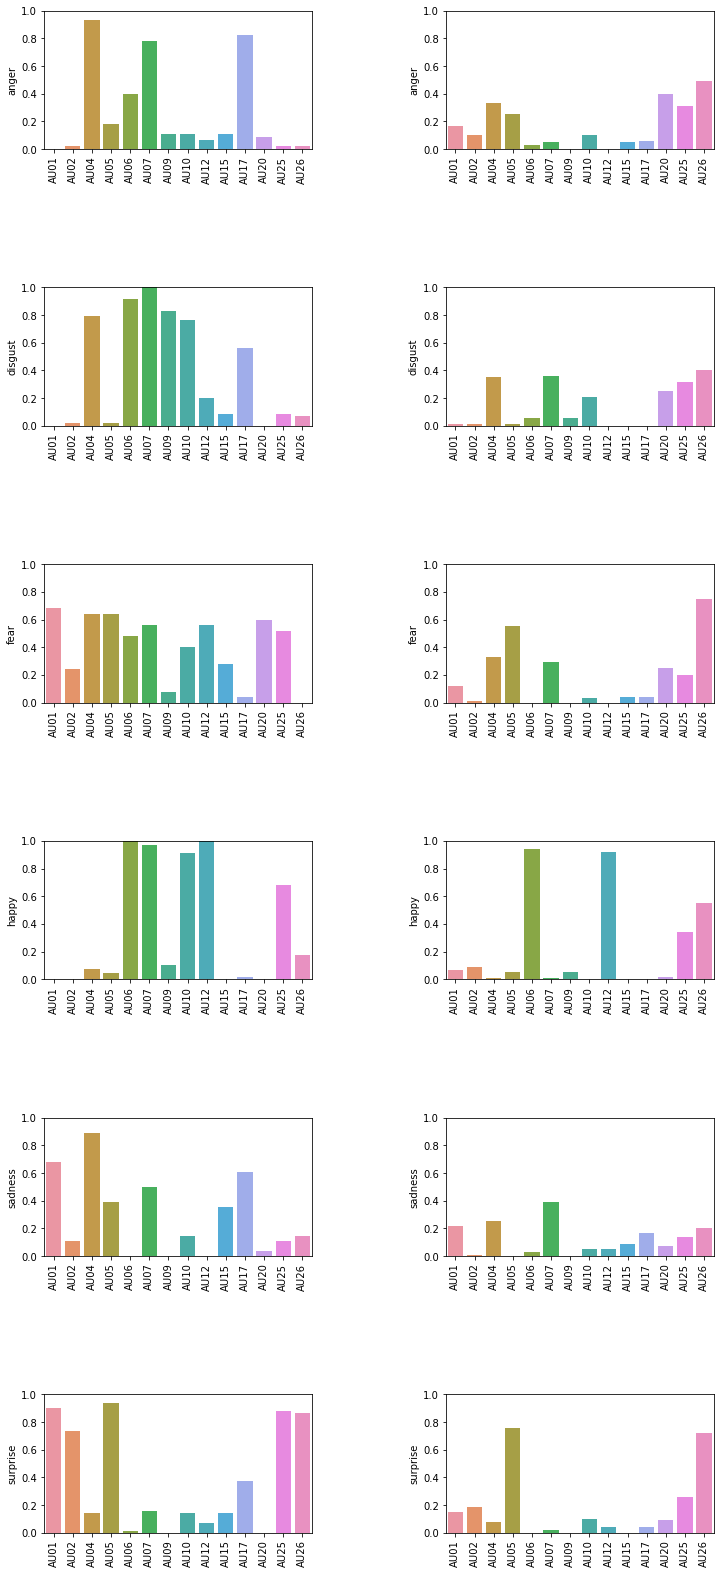

In [27]:
fig, axes = plt.subplots(6, 2, figsize=(12,28))

i = 0
for emo in emo_map.values():

    if emo in emo_matrix.keys() and len(emo_matrix.keys())>i and emo_map_inv[emo] in lbl_counts:

        axes[i,0].set_ylabel(emo)
        axes[i,0].set(ylim=(0,1))
        _ = sns.barplot(x=AUmat_lbl,
                        y=data.loc[lambda data: data.emotion == emo_map_inv[emo], AUc_mat].sum()/lbl_counts[emo_map_inv[emo]],
                        ax=axes[i,0]
                       )
        
        for item in _.get_xticklabels():
            item.set_rotation(90)
        
        axes[i,1].set_ylabel(emo)
        axes[i,1].set(ylim=(0,1))

        _ = sns.barplot(x=AUmat_lbl,y=emo_matrix[emo], ax=axes[i,1])

        for item in _.get_xticklabels():
            item.set_rotation(90)
        
        i = i+1
    

plt.subplots_adjust(wspace=.5, hspace=1.0)

This comparison is aimed just to verify the classification data. It is not possible to infer the emotion from the classification output, because it doesn't carry enough information.

It is possible to recognize some affinities between the output and the matrix, but it is definitely the worst set of data among the three that we have analyzed.